In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
data = pd.read_csv('./DatasetCombined.csv', encoding='ISO-8859-1')

In [ ]:
# Preprocess data
X = data['TEXT']
y = data['LABEL'].map({'ham': 0, 'smishing': 1})

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Feature extraction
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Check for NaN values in y
print("Number of NaN values in y before removing:", y_train.isna().sum(), y_test.isna().sum())

# Drop rows where y is NaN and update X_train and X_test accordingly
X_train = X_train[~y_train.isna()]
X_test = X_test[~y_test.isna()]
y_train = y_train.dropna()
y_test = y_test.dropna()

# Re-transform the text data into TF-IDF features after dropping NaN values
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Number of NaN values in y after removing:", y_train.isna().sum(), y_test.isna().sum())


Number of NaN values in y before removing: 1603 374
Number of NaN values in y after removing: 0 0


In [ ]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

In [ ]:
# Train and evaluate models
results = {}

for model_name, model in tqdm(models.items(), desc='Training Models'):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    y_prob = model.predict_proba(X_test_tfidf)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)

    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'precision_vals': precision_vals,
        'recall_vals': recall_vals
    }


Training Models: 100%|██████████| 5/5 [01:21<00:00, 16.27s/it]


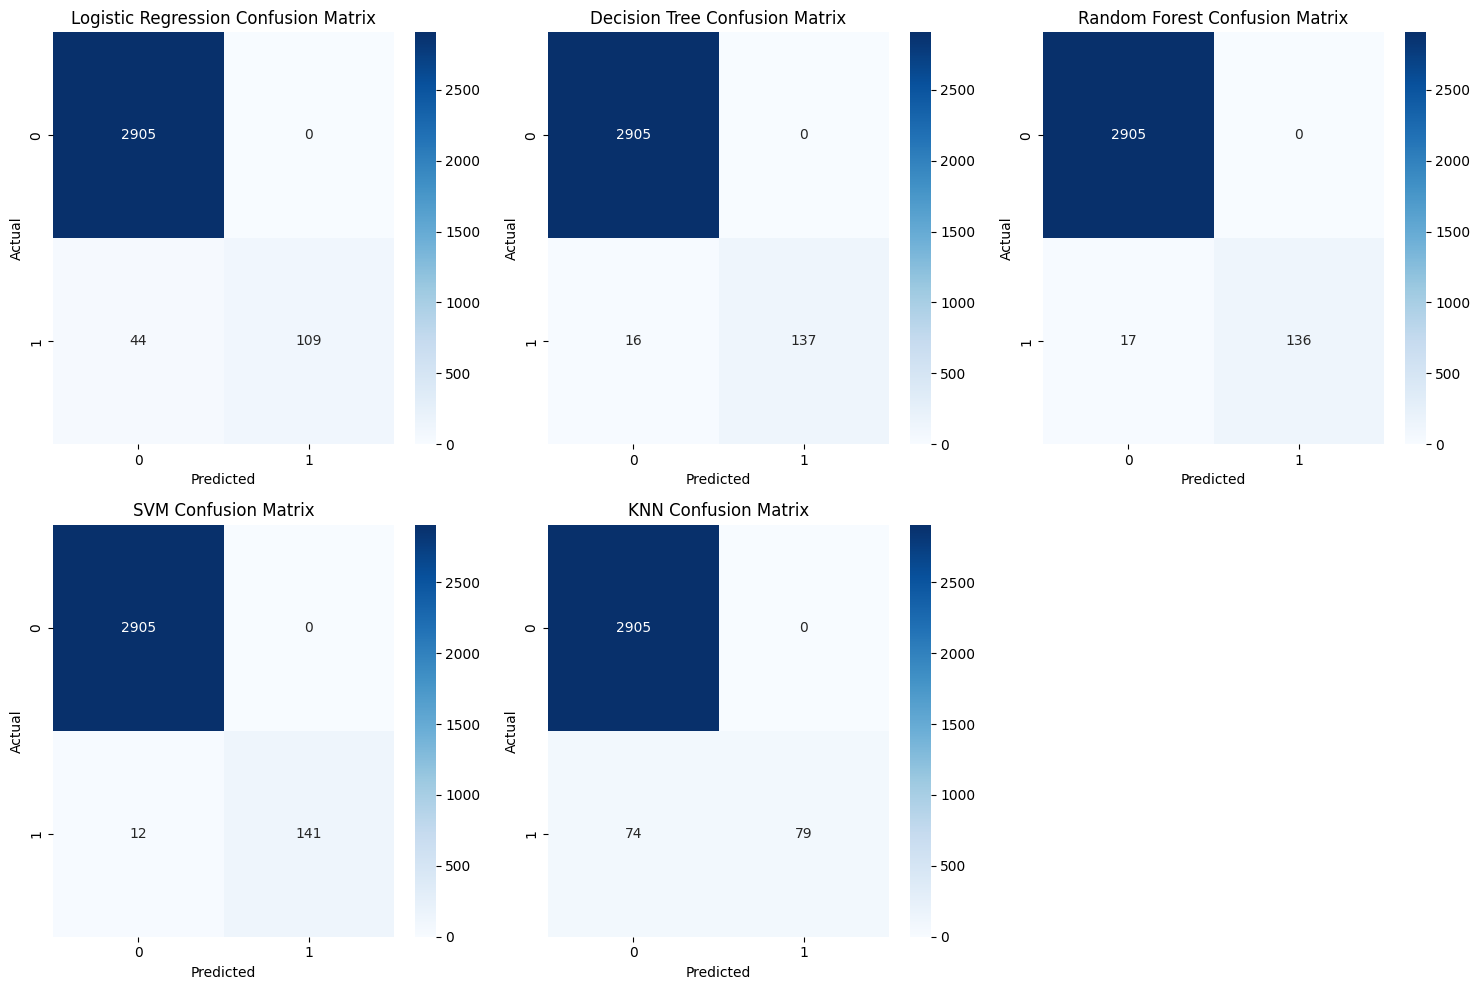

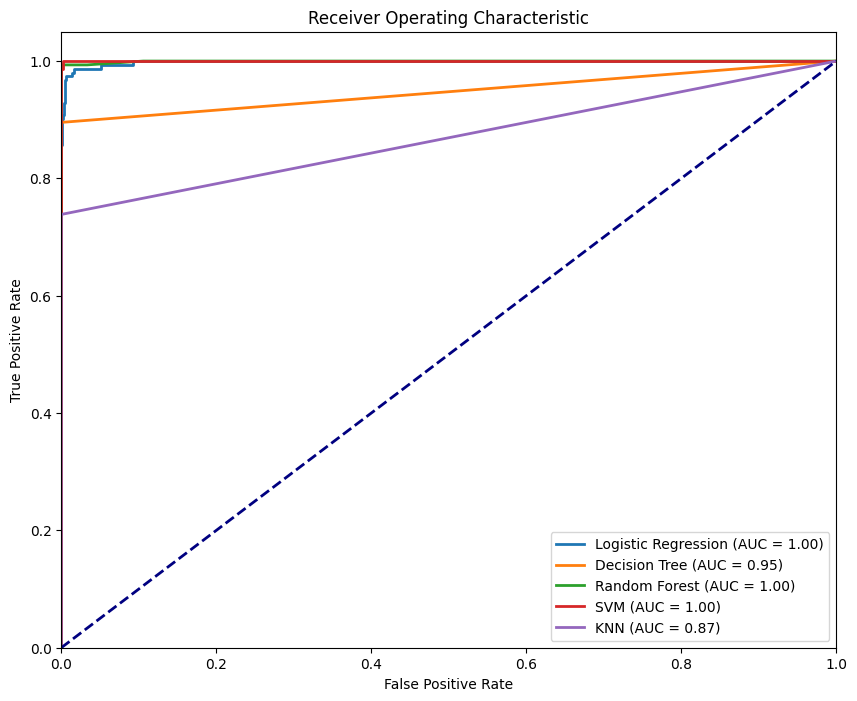

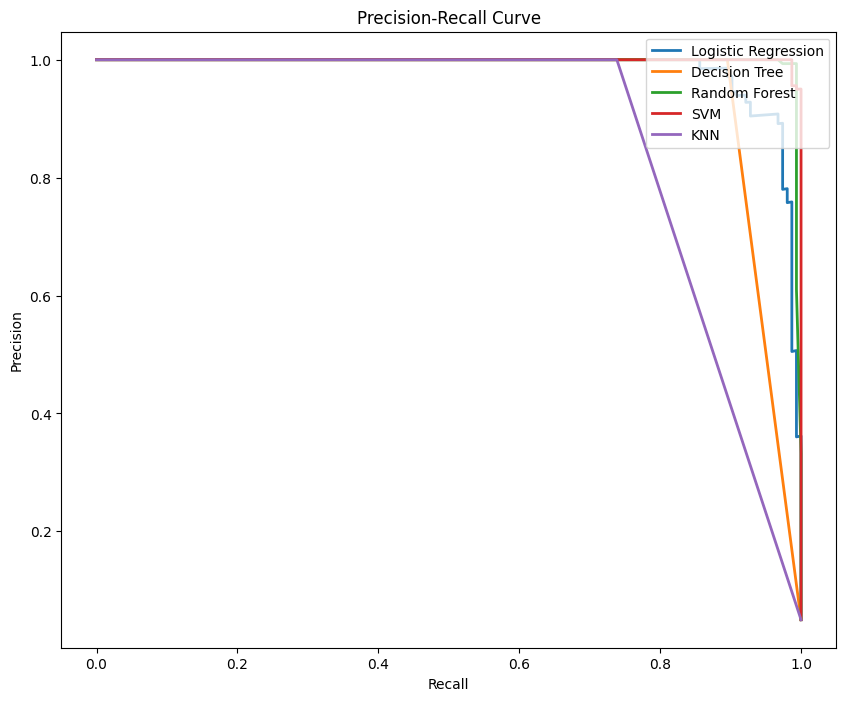

In [ ]:
# Plot metrics
def plot_metrics(results):
    plt.figure(figsize=(15, 10))

    # Confusion Matrices
    for i, (model_name, result) in enumerate(results.items(), 1):
        plt.subplot(2, 3, i)
        cm = confusion_matrix(y_test, models[model_name].predict(X_test_tfidf))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # ROC Curves
    plt.figure(figsize=(10, 8))
    for model_name, result in results.items():
        plt.plot(result['fpr'], result['tpr'], lw=2, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curves
    plt.figure(figsize=(10, 8))
    for model_name, result in results.items():
        plt.plot(result['recall_vals'], result['precision_vals'], lw=2, label=model_name)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()

# Plot results
plot_metrics(results)

In [ ]:
# Display overall comparison
comparison = pd.DataFrame(results).T[['accuracy', 'precision', 'recall', 'f1']]
print(comparison)

                     accuracy precision    recall        f1
Logistic Regression  0.985612       1.0  0.712418  0.832061
Decision Tree        0.994768       1.0  0.895425  0.944828
Random Forest        0.994441       1.0  0.888889  0.941176
SVM                  0.996076       1.0  0.921569  0.959184
KNN                  0.975801       1.0   0.51634  0.681034
